# 📊 Rule-Based Attribution Models

Implements traditional attribution models (what MMPs like Adjust/AppsFlyer use):
- **Last-Touch**: All credit to final touchpoint
- **First-Touch**: All credit to first touchpoint  
- **Linear**: Equal credit distribution
- **Time-Decay**: Exponential decay from conversion
- **Position-Based**: 40-20-40 distribution

These serve as baselines to compare against our deep learning approach.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import json
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Paths
DATA_PROCESSED = Path('../data/processed')
RESULTS = Path('../results')
(RESULTS / 'metrics').mkdir(parents=True, exist_ok=True)
(RESULTS / 'figures').mkdir(parents=True, exist_ok=True)

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load processed data
with open(DATA_PROCESSED / 'processed_sequences.pkl', 'rb') as f:
    data = pickle.load(f)

test_seq = data['test_sequences']
config = data['config']

print(f"Test sequences: {len(test_seq):,}")
print(f"Config: {json.dumps(config, indent=2, default=str)}")

Test sequences: 563,874
Config: {
  "n_campaigns": 676,
  "max_seq_len": 20,
  "sample_rows": 8000000,
  "n_train": 2631409,
  "n_val": 563873,
  "n_test": 563874,
  "conversion_rate": 0.05018546716337391,
  "time_delta_mean": 169292.26415339683,
  "time_delta_std": 214311.97134808675,
  "created_at": "2025-12-15T05:05:43.889145",
  "feature_dim": 4
}


## Attribution Model Implementations

In [3]:
class RuleBasedAttribution:
    """Collection of traditional attribution models used by MMPs."""
    
    @staticmethod
    def last_touch(seq_len):
        """100% credit to the last touchpoint (default MMP behavior)."""
        weights = np.zeros(seq_len)
        weights[-1] = 1.0
        return weights
    
    @staticmethod
    def first_touch(seq_len):
        """100% credit to the first touchpoint."""
        weights = np.zeros(seq_len)
        weights[0] = 1.0
        return weights
    
    @staticmethod
    def linear(seq_len):
        """Equal credit to all touchpoints."""
        return np.ones(seq_len) / seq_len
    
    @staticmethod
    def time_decay(seq_len, half_life=3):
        """Exponential decay - more credit to recent touchpoints."""
        positions = np.arange(seq_len)[::-1]  # Countdown from last
        weights = np.exp(-np.log(2) / half_life * positions)
        return weights / weights.sum()
    
    @staticmethod
    def position_based(seq_len):
        """40% first, 40% last, 20% split across middle."""
        if seq_len == 1:
            return np.array([1.0])
        if seq_len == 2:
            return np.array([0.5, 0.5])
        
        weights = np.zeros(seq_len)
        weights[0] = 0.4
        weights[-1] = 0.4
        if seq_len > 2:
            weights[1:-1] = 0.2 / (seq_len - 2)
        return weights

# Demonstrate with example
print("Attribution weights for 5-touchpoint journey:")
print(f"  Last-Touch:     {RuleBasedAttribution.last_touch(5)}")
print(f"  First-Touch:    {RuleBasedAttribution.first_touch(5)}")
print(f"  Linear:         {RuleBasedAttribution.linear(5)}")
print(f"  Time-Decay:     {np.round(RuleBasedAttribution.time_decay(5), 3)}")
print(f"  Position-Based: {np.round(RuleBasedAttribution.position_based(5), 3)}")

Attribution weights for 5-touchpoint journey:
  Last-Touch:     [0. 0. 0. 0. 1.]
  First-Touch:    [1. 0. 0. 0. 0.]
  Linear:         [0.2 0.2 0.2 0.2 0.2]
  Time-Decay:     [0.12  0.151 0.19  0.239 0.301]
  Position-Based: [0.4   0.067 0.067 0.067 0.4  ]


## Compute Attribution for Test Set

In [4]:
def compute_campaign_attribution(sequences, model_func, **kwargs):
    """Compute attribution credit per campaign using a rule-based model.
    
    Only considers converting users (as they are the ones being attributed).
    """
    campaign_credits = {}
    campaign_costs = {}
    campaign_counts = {}  # Number of times campaign appeared in sequence
    
    # Only consider converting users
    converted_seq = [s for s in sequences if s['converted'] == 1]
    
    for seq in converted_seq:
        real_len = seq['seq_len']
        weights = model_func(real_len, **kwargs)
        
        # Get real touchpoints (non-padded)
        max_len = len(seq['campaigns'])
        start_idx = max_len - real_len
        campaigns = seq['campaigns'][start_idx:]
        costs = seq['costs'][start_idx:]
        
        for i, (camp, cost) in enumerate(zip(campaigns, costs)):
            if camp > 0:  # Skip padding (0)
                if camp not in campaign_credits:
                    campaign_credits[camp] = 0
                    campaign_costs[camp] = 0
                    campaign_counts[camp] = 0
                campaign_credits[camp] += weights[i]
                campaign_costs[camp] += cost
                campaign_counts[camp] += 1
    
    return campaign_credits, campaign_costs, campaign_counts

# Compute for all models
models = {
    'Last-Touch': (RuleBasedAttribution.last_touch, {}),
    'First-Touch': (RuleBasedAttribution.first_touch, {}),
    'Linear': (RuleBasedAttribution.linear, {}),
    'Time-Decay': (RuleBasedAttribution.time_decay, {}),
    'Position-Based': (RuleBasedAttribution.position_based, {})
}

results = {}
for name, (func, kwargs) in models.items():
    credits, costs, counts = compute_campaign_attribution(test_seq, func, **kwargs)
    results[name] = {'credits': credits, 'costs': costs, 'counts': counts}
    print(f"{name}: {len(credits)} campaigns with credit")

# Stats
n_converted = sum(1 for s in test_seq if s['converted'] == 1)
print(f"\nConverted users in test set: {n_converted:,}")

Last-Touch: 668 campaigns with credit
First-Touch: 668 campaigns with credit
Linear: 668 campaigns with credit
Time-Decay: 668 campaigns with credit
Position-Based: 668 campaigns with credit

Converted users in test set: 28,299


## Compare Attribution Distributions

In [5]:
# Compare top campaigns
top_n = 10
lt_credits = results['Last-Touch']['credits']
top_campaigns = sorted(lt_credits.keys(), key=lambda x: lt_credits.get(x, 0), reverse=True)[:top_n]

comparison_data = {}
for model_name in models.keys():
    credits = results[model_name]['credits']
    total = sum(credits.values())
    comparison_data[model_name] = [credits.get(c, 0) / total * 100 for c in top_campaigns]

comparison_df = pd.DataFrame(comparison_data, index=[f'Camp_{c}' for c in top_campaigns])

print("Attribution by Model (top 10 campaigns, %):")
print(comparison_df.round(2).to_string())

Attribution by Model (top 10 campaigns, %):
          Last-Touch  First-Touch  Linear  Time-Decay  Position-Based
Camp_218        4.52         4.55    4.53        4.53            4.54
Camp_327        3.39         3.44    3.41        3.40            3.41
Camp_201        3.28         3.21    3.26        3.27            3.25
Camp_641        3.06         3.05    3.02        3.02            3.04
Camp_669        2.91         2.86    2.93        2.93            2.90
Camp_53         2.33         2.29    2.32        2.32            2.31
Camp_112        2.10         2.07    2.08        2.08            2.08
Camp_330        2.02         1.99    1.99        1.98            2.00
Camp_102        1.72         1.90    1.82        1.80            1.81
Camp_599        1.69         1.63    1.68        1.69            1.67


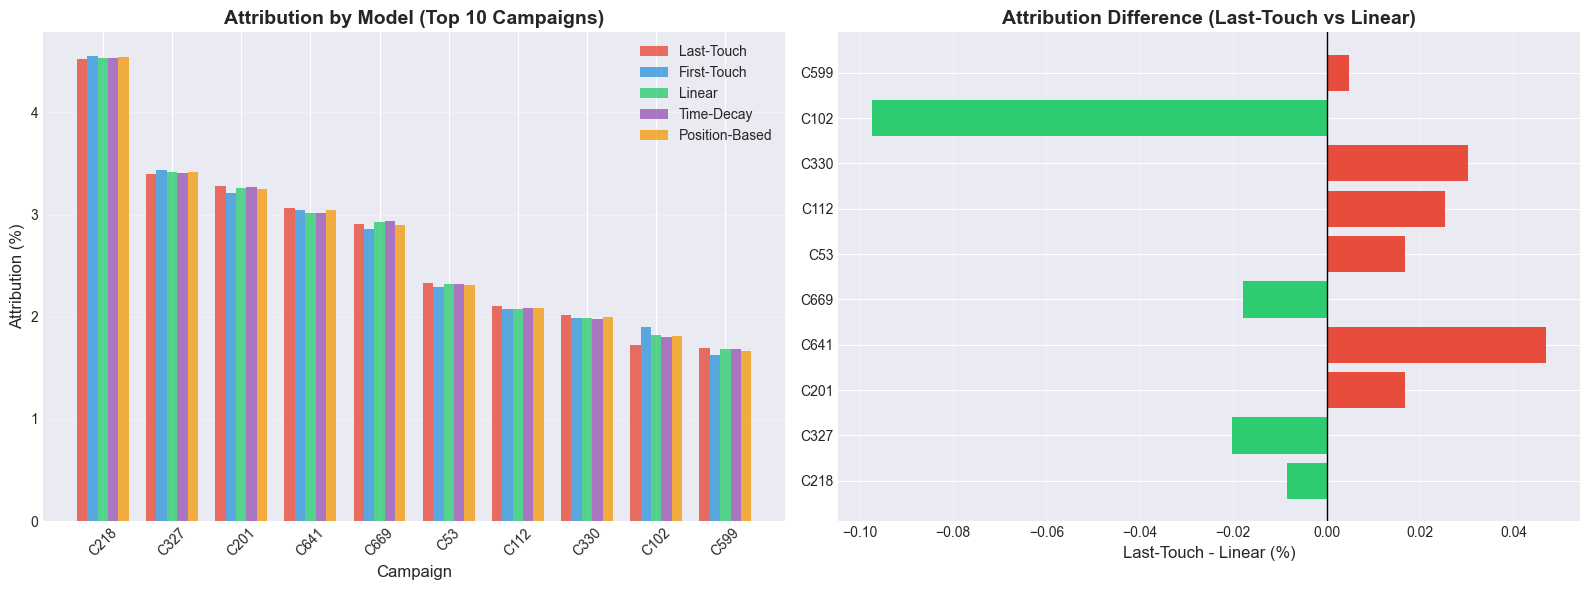

In [6]:
# Visualize differences
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Bar comparison
x = np.arange(len(top_campaigns))
width = 0.15
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12']

for i, (model_name, color) in enumerate(zip(models.keys(), colors)):
    offset = (i - 2) * width
    axes[0].bar(x + offset, comparison_data[model_name], width, label=model_name, color=color, alpha=0.8)

axes[0].set_ylabel('Attribution (%)', fontsize=12)
axes[0].set_xlabel('Campaign', fontsize=12)
axes[0].set_title('Attribution by Model (Top 10 Campaigns)', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'C{c}' for c in top_campaigns], rotation=45)
axes[0].legend(loc='upper right')
axes[0].grid(axis='y', alpha=0.3)

# Right: Last-Touch vs Linear difference
diff = np.array(comparison_data['Last-Touch']) - np.array(comparison_data['Linear'])
colors_diff = ['#e74c3c' if d > 0 else '#2ecc71' for d in diff]
axes[1].barh([f'C{c}' for c in top_campaigns], diff, color=colors_diff)
axes[1].axvline(x=0, color='black', linewidth=1)
axes[1].set_xlabel('Last-Touch - Linear (%)', fontsize=12)
axes[1].set_title('Attribution Difference (Last-Touch vs Linear)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS / 'figures' / 'rule_based_attribution.png', dpi=150, bbox_inches='tight')
plt.show()

## Key Insights

In [7]:
# Find campaigns most affected by attribution model choice
lt = pd.Series(comparison_data['Last-Touch'], index=comparison_df.index)
lin = pd.Series(comparison_data['Linear'], index=comparison_df.index)
diff = lt - lin

print("=" * 60)
print("KEY INSIGHTS: MODEL DISAGREEMENT")
print("=" * 60)

print(f"\n🔴 Campaigns OVERCREDITED by Last-Touch (vs Linear):")
for idx in diff.nlargest(3).index:
    print(f"   {idx}: +{diff[idx]:.1f}% more credit under Last-Touch")

print(f"\n🟢 Campaigns UNDERCREDITED by Last-Touch (vs Linear):")
for idx in diff.nsmallest(3).index:
    print(f"   {idx}: {diff[idx]:.1f}% less credit under Last-Touch")

print(f"\n📊 Maximum disagreement: {abs(diff).max():.1f}%")
print("\n💡 This shows why rule-based attribution is problematic!")
print("   Different models give completely different budget recommendations.")

KEY INSIGHTS: MODEL DISAGREEMENT

🔴 Campaigns OVERCREDITED by Last-Touch (vs Linear):
   Camp_641: +0.0% more credit under Last-Touch
   Camp_330: +0.0% more credit under Last-Touch
   Camp_112: +0.0% more credit under Last-Touch

🟢 Campaigns UNDERCREDITED by Last-Touch (vs Linear):
   Camp_102: -0.1% less credit under Last-Touch
   Camp_327: -0.0% less credit under Last-Touch
   Camp_669: -0.0% less credit under Last-Touch

📊 Maximum disagreement: 0.1%

💡 This shows why rule-based attribution is problematic!
   Different models give completely different budget recommendations.


In [8]:
# Save results
baseline_results = {
    'attribution': comparison_df.to_dict(),
    'raw_results': results,
    'top_campaigns': top_campaigns,
    'n_converted': n_converted
}

with open(RESULTS / 'metrics' / 'baseline_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

print(f"\n✅ Baseline models complete!")
print(f"   Saved to: {RESULTS / 'metrics' / 'baseline_results.pkl'}")


✅ Baseline models complete!
   Saved to: ..\results\metrics\baseline_results.pkl


---
**Next:** [04_lstm_attribution.ipynb](04_lstm_attribution.ipynb) - Deep learning approach